In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import time


### Question 4

##### a. Simulate the Moran birth-death model, plot some trajectories over time and see whether you can recapture the result we derived in class. (The probability of fixation is 1/N , for a given N fixed population size.

In [2]:
def simulation(N):
    i = 1
    A_population = [i]
    start_time = time.time()
    
    while (i != 0) and (i != N):
        f = random.uniform(0, 1)
        if f < (i*(N-i))/(N*N):
            i -= 1
        elif (f >= (i*(N-i))/(N*N)) and (f < (2*i*(N-i))/(N*N)):
            i += 1
        elif f >= (2*i*(N-i))/(N*N):
            continue
        
        A_population.append(i)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return A_population, elapsed_time

def run_simulation(N, num_simulations):
    absorptions_N = 0
    total_time = 0
    
    A_populations = []

    for t in range(num_simulations):
        A_population, elapsed_time = simulation(N)
        total_time += elapsed_time
        if A_population[-1] == N:
            absorptions_N += 1
        A_populations.append(A_population)

    absorption_rate_N = absorptions_N / num_simulations
    average_time_per_simulation = total_time / num_simulations

    return absorption_rate_N, A_populations, average_time_per_simulation



Absorption rate: 0.013


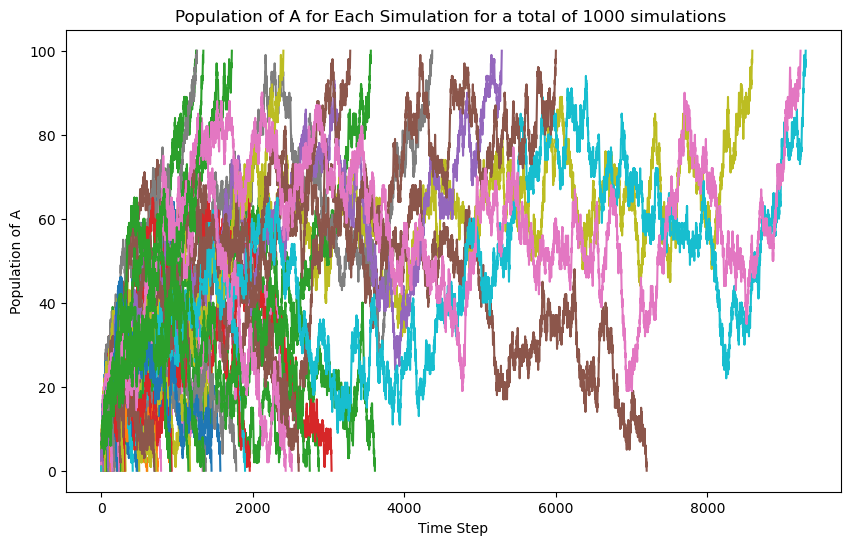

In [3]:
# Parameters
N = 100  
num_simulations = 1000 


absorption_rate_N, A_populations, average_time_per_simulation = run_simulation(N, num_simulations)
print('Absorption rate:', absorption_rate_N)

plt.figure(figsize=(10, 6))
for i, A_population in enumerate(A_populations):
    plt.plot(range(len(A_population)), A_population,)

plt.xlabel('Time Step')
plt.ylabel('Population of A')
plt.title(f'Population of A for Each Simulation for a total of {num_simulations} simulations ')
plt.show()



##### b. If we now assume a selective benefit of s for allele A (such that B individuals have probability 1 to give birth and A individuals have probability (1+s)) discuss (using simulations) how this changes the probability of fixation for A.

In [4]:
def simulation_s(s, N):
    i = 1
    A_population = [i]

    while (i != 0) and (i != N):
        f = random.uniform(0, 1)
        probabilities = [(N-i)*i/(((s+1)*i+N-i)*N),(s+1)*i*(N-i)/(((s+1)*i+N-i)*N)]
        if (f < probabilities[0]):
            i -= 1
        elif (f >= probabilities[0]) and (f < sum(probabilities)):
            i += 1
        elif (f >= sum(probabilities)):
            continue
        A_population.append(i)
    return A_population

def run_simulation_s(s_values, N, num_simulations):
    A_populations = []

    for s in s_values:
        s_population = []
        for _ in range(num_simulations):
            final = simulation_s(s, N)
            s_population.append(final)
        A_populations.append(s_population)

    return A_populations

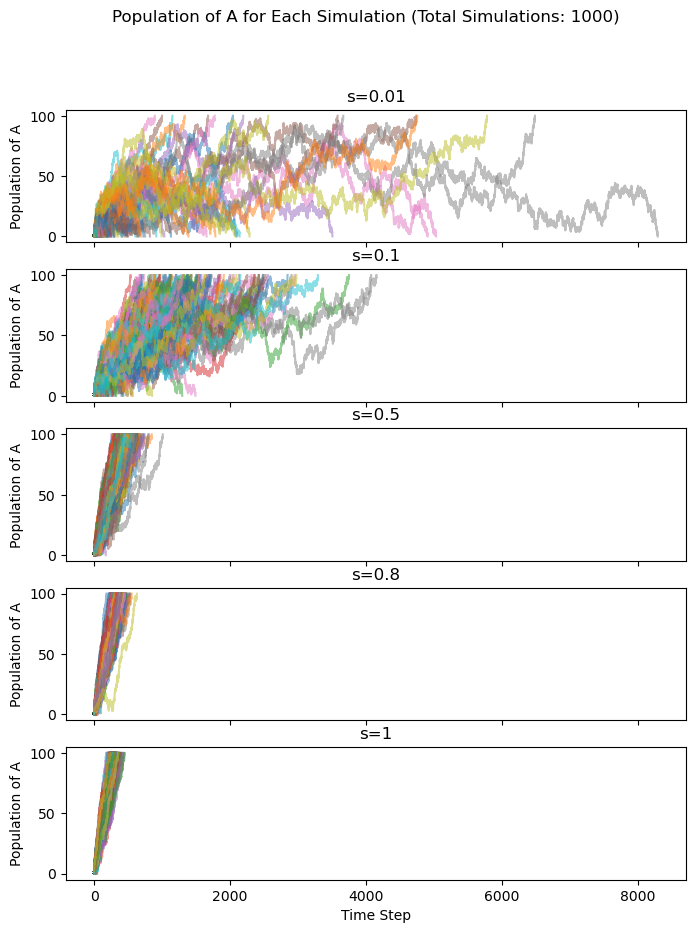

In [5]:
s_values = [0.01, 0.1, 0.5, 0.8, 1]
N = 100  
num_simulations = 1000  

result = run_simulation_s(s_values, N, num_simulations)


fig, axes = plt.subplots(len(s_values), 1, figsize=(8, 10), sharex=True, sharey=True)

for i, s in enumerate(s_values):
    A_populations = run_simulation_s([s], N, num_simulations)[0]
    
    for A_population in A_populations:
        # color = plt.cm.viridis(i / len(s_values))  
        axes[i].plot(range(len(A_population)), A_population, alpha=0.5)

    axes[i].set_title(f's={s}')
    axes[i].set_ylabel('Population of A')

axes[-1].set_xlabel('Time Step')
plt.suptitle(f'Population of A for Each Simulation (Total Simulations: {num_simulations})')
plt.show()

### Question 5

##### b. Suppose that βS > c + d. (This means that in a deterministic version of this stochastic model the number of infections would increase). What is the probability that global pandemic will occur, starting from one infection? You can use simulations to find this probability (as a function of parameters, that you can plot on the x axis). Use what we know about birth death Markov Chains (including online content or chatGPT) and see if you can derive this probability analytically.

In [6]:
def simulation_det(beta, S, c, d, threshold_val, num_simulations):
    for _ in range(num_simulations):
        infected = 1  
        all_infected = [infected]
        sim_counter = 0       
        pandemic_counter = 0
        while 0 < infected < threshold_val:
            sim_counter += 1
            r1 = beta * infected
            r2= (c + d) * infected
            stable = 1-(r1+r2)
            
            if stable < 0:
                stable = 0

            all_rates = [r1, r2, stable]
            event = np.random.choice([1, -1, 0], p=[rate / sum(all_rates) for rate in all_rates])
            infected += event
            all_infected.append(infected)
    return all_infected, infected, sim_counter
      

In [7]:
def deterministic_version(beta, S, c, d, thresholds, num_simulations):
    total_probabilities = []
    for thres in thresholds:
        total_pandemics = 0
        pandemic_counter = 0
        
        all_inf, inf, sim_counter = simulation_det(beta, S, c, d, thres, num_simulations)
        
        total_pandemics += 1
        pandemic_counter += 1
        
        prob =1 / sim_counter
        total_probabilities.append(prob)
    return total_probabilities
    

In [8]:
def analytical_version(beta, S, c, d,thresholds, num_simulations):
    avg_probs = []
    for thres in thresholds:
        probs = []
        for i in range(num_simulations):
            denominator = 1 - (((c+d)/(beta)) **(thres-1))
            ind_prob = (1 - ((c+d)/(beta)))/denominator
            probs.append(ind_prob)
        average_prob_of_pandemic = sum(probs)/len(probs)
        avg_probs.append(average_prob_of_pandemic)
    return avg_probs

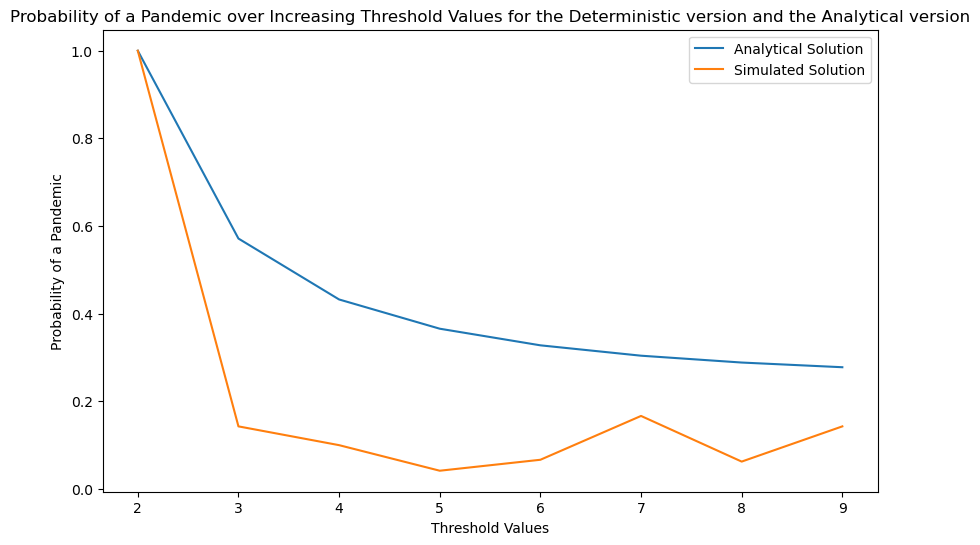

In [28]:
beta = 0.2
S = 100  
c = 0.1 
d = 0.05  
threshold_values = range(2, 10, 1)  
num_simulations = 10 


ana_probs = analytical_version(beta, S, c, d,threshold_values, num_simulations)
sim_probs = deterministic_version(beta, S, c, d, threshold_values, num_simulations)


plt.figure(figsize=(10, 6))
plt.plot(threshold_values, ana_probs, label="Analytical Solution")
plt.plot(threshold_values, sim_probs, label="Simulated Solution")
plt.xlabel('Threshold Values')
plt.ylabel('Probability of a Pandemic')
plt.title('Probability of a Pandemic over Increasing Threshold Values for the Deterministic version and the Analytical version')
plt.legend()
plt.show()
